In [1]:
import pandas as pd
import numpy as np

import csv   
import math
import matplotlib.pyplot as plt
import datetime

import librosa as lr
import librosa.display as lrd
%matplotlib inline
%load_ext rpy2.ipython

/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: During startup - 
  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Warning message:

  warnings.warn(x, RRuntimeWarning)
/home/thib/.virtualenvs/keras/local/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Setting LC_CTYPE failed, using "C" 

  warnings.warn(x, RRuntimeWarning)


In [2]:
SPLIT_TRAIN_TEST = .8
TARGET_FILE = '../data/noisemaker_light/noisemaker_light.csv'
SAMPLES_FOLDER = '../data/noisemaker_light/noisemaker_light_samples/'
FOLDER_PREFIX = 'noisemaker_light'

D = str(datetime.datetime.now())
RESULTS_FILE = 'RESULTS-' + FOLDER_PREFIX + '-' + D[:16].replace(' ','_') + '.csv'
print RESULTS_FILE

HOP_LENGTH = 512

N_MFCC = 20
N_MEL = 32

N_EPOCHS = 250
BATCH_SIZE = 32
VERBOSE = 1
VALIDATION = .1

RESULTS-noisemaker_light-2018-01-09_18:07.csv


# Prepares datasets

In [3]:
# Prepares labels
Y = pd.read_csv(TARGET_FILE)
print Y.head()

len_train = int(Y.shape[0]*.8)
len_test = int(Y.shape[0]*.2)
print len_train, len_test

Y_train = Y.iloc[:len_train,:]
Y_test = Y.iloc[len_train:,:]
print 
print 'Training data:', Y_train.shape
print 'Test data:', Y_test.shape

Y_train, files_train =  Y_train.drop('file', axis=1), Y_train['file']
Y_test, files_test = Y_test.drop('file', axis=1), Y_test['file']
print
print files_train[:5]
print files_test[:5]

   lfo1_rate  filter_cutoff  lfo1_amount osc2_wave  filter_resonance    file
0   0.629921       1.811024     2.755906      Sine          1.653543  s0.wav
1   8.818898       1.496063     1.653543      Sine          3.464567  s1.wav
2   5.590551       8.346457     5.118110     Pulse          4.251969  s2.wav
3   6.535433       9.291339     5.748031       Saw          5.039370  s3.wav
4   9.212598       0.078740     4.803150     Pulse          6.614173  s4.wav
800 200

Training data: (800, 6)
Test data: (200, 6)

0    s0.wav
1    s1.wav
2    s2.wav
3    s3.wav
4    s4.wav
Name: file, dtype: object
800    s800.wav
801    s801.wav
802    s802.wav
803    s803.wav
804    s804.wav
Name: file, dtype: object


In [4]:
# Loads waveforms
sampling_rate = lr.load(SAMPLES_FOLDER + files_train[0])[1]
print 'Sampling rate:', sampling_rate

waveforms_test = []
for i, file_name in enumerate(files_test):
    if i % 100 == 0:
        print 'Loaded testing waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_test.append(lr.load(f)[0])
X_test = np.stack(waveforms_test)
print X_test.shape


waveforms_train = []
for i, file_name in enumerate(files_train):
    if i % 100 == 0:
        print 'Loaded training waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_train.append(lr.load(f)[0])
X_train = np.stack(waveforms_train)
print X_train.shape

Sampling rate: 22050
Loaded testing waveform #0
Loaded testing waveform #100
(200, 19845)
Loaded training waveform #0
Loaded training waveform #100
Loaded training waveform #200
Loaded training waveform #300
Loaded training waveform #400
Loaded training waveform #500
Loaded training waveform #600
Loaded training waveform #700
(800, 19845)


# Independent models

## Prepares the features

In [ ]:
L_test_mfcc = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_test_mfcc.append(mfcc)
X_test_mfcc = np.stack(L_test_mfcc)
print X_test_mfcc.shape

L_train_mfcc = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_train_mfcc.append(mfcc)
X_train_mfcc = np.stack(L_train_mfcc)
print X_train_mfcc.shape

In [ ]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mfcc[140,...], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [ ]:
X_test_mfcc = np.reshape(X_test_mfcc, (X_test_mfcc.shape[0],-1))
X_train_mfcc = np.reshape(X_train_mfcc, (X_train_mfcc.shape[0],-1))
print X_test_mfcc.shape
print X_train_mfcc.shape

## Predictions

In [ ]:
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

headers=['algo', 'type', 'param1','param2','regularization',
         'target','metric', 'train_score', 'test_score']
with open(RESULTS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

def evaluate_algo(algo_label, grid_reg, grid_class):
    results = []
    for t_i, t_name in enumerate(list(Y_train)):
        print 'predicting feature', t_name
        y_train = Y_train[[t_name]].values.flatten()
        y_test = Y_test[[t_name]].values.flatten()
        print y_train.dtype
        
        best_params_C = None
        best_params_R = None
        
        try:
            # Case 1: classification
            if y_train.dtype == 'object':

                metric = 'class'

                # Cross-Validation Score
                grid_class.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_class.best_score_
                best_params_C = grid_class.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_class.predict(X_test_mfcc)
                test_score = accuracy_score(test_pred, y_test)
                print test_score


            # Case 2: regression
            elif y_train.dtype == 'float64':

                metric = 'reg'

                # Cross-Validation Score
                grid_reg.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_reg.best_score_ * -1
                best_params_R = grid_reg.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_reg.predict(X_test_mfcc)
                test_score = mean_absolute_error(test_pred, y_test)
                print test_score

            else:
                raise ValueError('Wrong Column Type')

            out = (algo_label, 'per_output', best_params_R, best_params_C,None,
                   t_name, metric, cross_val_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

        except:
            print "Unexpected error:", sys.exc_info()[0]

In [ ]:
from sklearn import neighbors

algo_C =neighbors.KNeighborsClassifier()
grid_C = GridSearchCV(algo_C, {"n_neighbors":[3,5,8,16]}, scoring='accuracy', verbose=2)

algo_R =neighbors.KNeighborsRegressor()
grid_R = GridSearchCV(algo_R, {"n_neighbors":[3,5,8,16]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('kNN', grid_R, grid_C)

In [ ]:
from sklearn import tree

algo_C = tree.DecisionTreeClassifier()
grid_C = GridSearchCV(algo_C, {"max_depth":[2,4,8,16,32,64,128]}, scoring='accuracy', verbose=2)

algo_R = tree.DecisionTreeRegressor()
grid_R = GridSearchCV(algo_R, {"max_depth":[2,4,8,16,32,64,128]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Decision Tree', grid_R, grid_C)

In [ ]:
from sklearn import dummy

algo_C = dummy.DummyClassifier()
grid_C = GridSearchCV(algo_C, {"strategy":["most_frequent"]}, scoring='accuracy', verbose=2)

algo_R = dummy.DummyRegressor()
grid_R = GridSearchCV(algo_R, {"strategy":["mean"]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Naive', grid_R, grid_C)

In [ ]:
# from sklearn import svm

# algo_R = svm.SVR(kernel='linear')
# grid_R = GridSearchCV(algo_R, {'C':[.01, .1, 1.]},
#                       scoring='neg_mean_absolute_error', verbose=2,
#                      n_jobs =4)

# algo_C = svm.SVC(kernel='linear')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1.]},
#                       scoring='accuracy', verbose=2,
#                       n_jobs =4)


# evaluate_algo('SVM_lin', grid_R, grid_C)

# algo_R = svm.SVR(kernel='RBF')
# grid_R = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='neg_mean_absolute_error', verbose=2)

# algo_C = svm.SVC(kernel='RBF')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='accuracy', verbose=2)


# evaluate_algo('SVM_RBF', grid_R, grid_C)

# Joint modelling + mid-level features

In [6]:
import collections

def target_info(df_y):
    infos = collections.OrderedDict()
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

lfo1_rate
filter_cutoff
lfo1_amount
osc2_wave
filter_resonance
OrderedDict([('lfo1_rate', {'sd': 2.8756837733162297, 'type': dtype('float64'), 'mean': 5.064960629921563}), ('filter_cutoff', {'sd': 2.89234557524474, 'type': dtype('float64'), 'mean': 5.0103346456694338}), ('lfo1_amount', {'sd': 2.932316237542842, 'type': dtype('float64'), 'mean': 4.9543307086615656}), ('osc2_wave', {'char2int': {'Sine': 3, 'Noise': 0, 'Saw': 2, 'Triangle': 4, 'Pulse': 1}, 'int2char': {0: 'Noise', 1: 'Pulse', 2: 'Saw', 3: 'Sine', 4: 'Triangle'}, 'type': dtype('O')}), ('filter_resonance', {'sd': 2.9479893137687894, 'type': dtype('float64'), 'mean': 5.0626968503939489})])


In [7]:
L_test_mel = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_test_mel.append(mel)
X_test_mel = np.stack(L_test_mel)
print X_test_mel.shape

L_train_mel = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_train_mel.append(mel)
X_train_mel = np.stack(L_train_mel)
print X_train_mel.shape

(200, 32, 39)
(800, 32, 39)


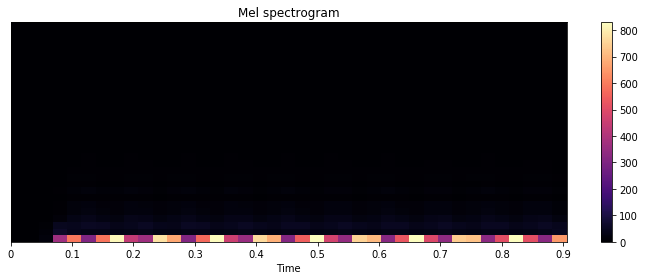

In [8]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mel[1,...], x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')
plt.tight_layout()

In [9]:
X_train_mel = np.transpose(X_train_mel, (0,2,1))
X_test_mel = np.transpose(X_test_mel, (0,2,1))
print X_train_mel.shape, X_test_mel.shape

(800, 39, 32) (200, 39, 32)


In [10]:
def format_output(Y):
    out = {}
    for name,infos in Y_info.iteritems():
        if infos['type'] == 'float64':
            y = (Y[name] - infos['mean']) / infos['sd']
            
        elif infos['type'] == 'object':
            char2int = infos['char2int']
            y = np.zeros((len(Y[name]), len(char2int)))
            for i,yval in enumerate(Y[name]):
                y[i, char2int[yval]] = 1
                
        else:
            raise ValueError
        
        print name, y.shape
        out[name] = y
    
    return out

        
def test_model(label, params1, params2, regul, model):
    
    # Prepares input and output data
    X_mean = np.mean(X_train_mel, axis=(0))
    X_sd = np.std(X_train_mel, axis=(0))
    
    X_train = (X_train_mel - X_mean) / X_sd
    X_test  = (X_test_mel - X_mean) / X_sd
    
    Y_dict_train = format_output(Y_train)
    Y_dict_test  = format_output(Y_test)
    
    # Trains the model
    hist = model.fit(X_train, Y_dict_train, 
              epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
             validation_split = VALIDATION)
    
    # Makes predictions
    pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    
    # Gets validation and test scores (for each metric)
    Y = {}
    for j, Y_pred in enumerate(pred):
        t_name = Y_info.keys()[j]
        t_infos = Y_info[t_name]
        
        print t_name
        print Y_pred.shape

        if t_infos['type'] == 'float64':
            test_metric = 'reg'
            Y_pred = Y_pred.flatten()
            y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
            y_pred = y_pred.tolist()
            test_score = mean_absolute_error(y_pred, Y_test[t_name])
        
        elif t_infos['type'] == 'object':
            test_metric = 'class'
            y_i = np.argmax(Y_pred, axis=1)
            y_pred = [t_infos['int2char'][y] for y in y_i]
            test_score = accuracy_score(y_pred, Y_test[t_name])

        else:
            raise ValueError
        
        #train_scores = hist.history[t_name + '_loss'][-1]
        train_scores = -1 * hist.history['loss'][-1]
        out = (label, 'joint', params1, params2, regul,
               t_name, test_metric, train_scores, test_score)
        print out
        with open(RESULTS_FILE, 'a') as f:
            writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
            writer.writerow(out)

        Y[t_name] = y_pred
    
    Y = pd.DataFrame(Y)
    return Y

In [ ]:
# Model 1: 1 layer perceptron
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras import regularizers

def MLP(n_hidden_units, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = Flatten()(in_layer)
    for i in range(n_layers):
        h_layer = Dense(n_hidden_units, activation='relu')(h_layer)

    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name, 
                              kernel_regularizer=regularizers.l2(regul))(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, kernel_regularizer=regularizers.l2(regul),
                              activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [16,32,64]:
        for REGUL in [0,0.01,0.1]:
            model = MLP(N_UNITS, N_LAYERS, REGUL)
            out = test_model('MLP', N_UNITS, N_LAYERS, REGUL, model)

Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 39, 32)        0                                            
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 1248)          0                                            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 16)            19984                                        
____________________________________________________________________________________________________
lfo1_rate (Dense)                (None, 1)             17                                           
___________________________________________________________________________________________

720/720 [==============================] - 0s - loss: 2.9606 - lfo1_rate_loss: 0.7180 - filter_cutoff_loss: 0.5425 - lfo1_amount_loss: 0.7101 - osc2_wave_loss: 0.3763 - filter_resonance_loss: 0.6136 - val_loss: 3.4207 - val_lfo1_rate_loss: 0.9916 - val_filter_cutoff_loss: 0.5881 - val_lfo1_amount_loss: 0.7567 - val_osc2_wave_loss: 0.3683 - val_filter_resonance_loss: 0.7161
Epoch 17/250
720/720 [==============================] - 0s - loss: 2.9216 - lfo1_rate_loss: 0.7189 - filter_cutoff_loss: 0.5369 - lfo1_amount_loss: 0.7048 - osc2_wave_loss: 0.3589 - filter_resonance_loss: 0.6021 - val_loss: 3.4554 - val_lfo1_rate_loss: 0.9788 - val_filter_cutoff_loss: 0.6107 - val_lfo1_amount_loss: 0.7725 - val_osc2_wave_loss: 0.3577 - val_filter_resonance_loss: 0.7356
Epoch 18/250
720/720 [==============================] - 0s - loss: 2.9197 - lfo1_rate_loss: 0.7141 - filter_cutoff_loss: 0.5396 - lfo1_amount_loss: 0.7045 - osc2_wave_loss: 0.3530 - filter_resonance_loss: 0.6085 - val_loss: 3.4383 - va

720/720 [==============================] - 0s - loss: 2.5167 - lfo1_rate_loss: 0.6587 - filter_cutoff_loss: 0.4473 - lfo1_amount_loss: 0.6379 - osc2_wave_loss: 0.2350 - filter_resonance_loss: 0.5379 - val_loss: 3.3815 - val_lfo1_rate_loss: 1.0036 - val_filter_cutoff_loss: 0.6263 - val_lfo1_amount_loss: 0.7868 - val_osc2_wave_loss: 0.2429 - val_filter_resonance_loss: 0.7219
Epoch 37/250
720/720 [==============================] - 0s - loss: 2.4803 - lfo1_rate_loss: 0.6594 - filter_cutoff_loss: 0.4528 - lfo1_amount_loss: 0.6324 - osc2_wave_loss: 0.2317 - filter_resonance_loss: 0.5040 - val_loss: 3.4380 - val_lfo1_rate_loss: 1.0201 - val_filter_cutoff_loss: 0.6421 - val_lfo1_amount_loss: 0.7942 - val_osc2_wave_loss: 0.2553 - val_filter_resonance_loss: 0.7263
Epoch 38/250
720/720 [==============================] - 0s - loss: 2.5086 - lfo1_rate_loss: 0.6675 - filter_cutoff_loss: 0.4550 - lfo1_amount_loss: 0.6414 - osc2_wave_loss: 0.2267 - filter_resonance_loss: 0.5179 - val_loss: 3.3563 - va

720/720 [==============================] - 0s - loss: 2.3582 - lfo1_rate_loss: 0.6449 - filter_cutoff_loss: 0.4277 - lfo1_amount_loss: 0.6164 - osc2_wave_loss: 0.1756 - filter_resonance_loss: 0.4937 - val_loss: 3.4078 - val_lfo1_rate_loss: 1.0061 - val_filter_cutoff_loss: 0.6361 - val_lfo1_amount_loss: 0.8044 - val_osc2_wave_loss: 0.2160 - val_filter_resonance_loss: 0.7451
Epoch 58/250
720/720 [==============================] - 0s - loss: 2.3286 - lfo1_rate_loss: 0.6343 - filter_cutoff_loss: 0.4175 - lfo1_amount_loss: 0.6199 - osc2_wave_loss: 0.1702 - filter_resonance_loss: 0.4867 - val_loss: 3.3515 - val_lfo1_rate_loss: 1.0424 - val_filter_cutoff_loss: 0.6161 - val_lfo1_amount_loss: 0.7725 - val_osc2_wave_loss: 0.2039 - val_filter_resonance_loss: 0.7165
Epoch 59/250
720/720 [==============================] - 0s - loss: 2.3371 - lfo1_rate_loss: 0.6414 - filter_cutoff_loss: 0.4212 - lfo1_amount_loss: 0.6146 - osc2_wave_loss: 0.1681 - filter_resonance_loss: 0.4918 - val_loss: 3.4024 - va

720/720 [==============================] - 0s - loss: 2.2000 - lfo1_rate_loss: 0.6121 - filter_cutoff_loss: 0.3991 - lfo1_amount_loss: 0.5865 - osc2_wave_loss: 0.1527 - filter_resonance_loss: 0.4496 - val_loss: 3.4154 - val_lfo1_rate_loss: 1.0142 - val_filter_cutoff_loss: 0.6256 - val_lfo1_amount_loss: 0.8076 - val_osc2_wave_loss: 0.2308 - val_filter_resonance_loss: 0.7372
Epoch 79/250
720/720 [==============================] - 0s - loss: 2.2193 - lfo1_rate_loss: 0.6358 - filter_cutoff_loss: 0.4044 - lfo1_amount_loss: 0.5791 - osc2_wave_loss: 0.1426 - filter_resonance_loss: 0.4574 - val_loss: 3.4344 - val_lfo1_rate_loss: 1.0295 - val_filter_cutoff_loss: 0.6169 - val_lfo1_amount_loss: 0.7933 - val_osc2_wave_loss: 0.2462 - val_filter_resonance_loss: 0.7485
Epoch 80/250
720/720 [==============================] - 0s - loss: 2.1836 - lfo1_rate_loss: 0.6144 - filter_cutoff_loss: 0.3849 - lfo1_amount_loss: 0.5836 - osc2_wave_loss: 0.1410 - filter_resonance_loss: 0.4597 - val_loss: 3.4843 - va

720/720 [==============================] - 0s - loss: 2.0923 - lfo1_rate_loss: 0.6003 - filter_cutoff_loss: 0.3787 - lfo1_amount_loss: 0.5549 - osc2_wave_loss: 0.1256 - filter_resonance_loss: 0.4327 - val_loss: 3.4046 - val_lfo1_rate_loss: 1.0066 - val_filter_cutoff_loss: 0.5863 - val_lfo1_amount_loss: 0.8372 - val_osc2_wave_loss: 0.2439 - val_filter_resonance_loss: 0.7305
Epoch 99/250
720/720 [==============================] - 0s - loss: 2.0843 - lfo1_rate_loss: 0.6089 - filter_cutoff_loss: 0.3609 - lfo1_amount_loss: 0.5578 - osc2_wave_loss: 0.1260 - filter_resonance_loss: 0.4307 - val_loss: 3.3947 - val_lfo1_rate_loss: 0.9833 - val_filter_cutoff_loss: 0.6092 - val_lfo1_amount_loss: 0.8247 - val_osc2_wave_loss: 0.2384 - val_filter_resonance_loss: 0.7391
Epoch 100/250
720/720 [==============================] - 0s - loss: 2.1068 - lfo1_rate_loss: 0.6017 - filter_cutoff_loss: 0.3644 - lfo1_amount_loss: 0.5848 - osc2_wave_loss: 0.1214 - filter_resonance_loss: 0.4346 - val_loss: 3.4558 - v

720/720 [==============================] - 0s - loss: 2.0009 - lfo1_rate_loss: 0.5898 - filter_cutoff_loss: 0.3473 - lfo1_amount_loss: 0.5415 - osc2_wave_loss: 0.1135 - filter_resonance_loss: 0.4089 - val_loss: 3.4145 - val_lfo1_rate_loss: 0.9948 - val_filter_cutoff_loss: 0.5985 - val_lfo1_amount_loss: 0.8634 - val_osc2_wave_loss: 0.2424 - val_filter_resonance_loss: 0.7154
Epoch 120/250
720/720 [==============================] - 0s - loss: 2.0075 - lfo1_rate_loss: 0.5797 - filter_cutoff_loss: 0.3515 - lfo1_amount_loss: 0.5423 - osc2_wave_loss: 0.1124 - filter_resonance_loss: 0.4215 - val_loss: 3.3724 - val_lfo1_rate_loss: 0.9903 - val_filter_cutoff_loss: 0.6050 - val_lfo1_amount_loss: 0.8447 - val_osc2_wave_loss: 0.2061 - val_filter_resonance_loss: 0.7262
Epoch 121/250
720/720 [==============================] - 0s - loss: 1.9896 - lfo1_rate_loss: 0.5871 - filter_cutoff_loss: 0.3427 - lfo1_amount_loss: 0.5443 - osc2_wave_loss: 0.1099 - filter_resonance_loss: 0.4057 - val_loss: 3.4083 - 

720/720 [==============================] - 0s - loss: 1.9306 - lfo1_rate_loss: 0.5766 - filter_cutoff_loss: 0.3237 - lfo1_amount_loss: 0.5292 - osc2_wave_loss: 0.1048 - filter_resonance_loss: 0.3962 - val_loss: 3.4805 - val_lfo1_rate_loss: 1.0214 - val_filter_cutoff_loss: 0.5707 - val_lfo1_amount_loss: 0.8655 - val_osc2_wave_loss: 0.2429 - val_filter_resonance_loss: 0.7800
Epoch 140/250
720/720 [==============================] - 0s - loss: 1.9148 - lfo1_rate_loss: 0.5731 - filter_cutoff_loss: 0.3218 - lfo1_amount_loss: 0.5280 - osc2_wave_loss: 0.1060 - filter_resonance_loss: 0.3860 - val_loss: 3.5379 - val_lfo1_rate_loss: 1.0314 - val_filter_cutoff_loss: 0.6093 - val_lfo1_amount_loss: 0.8939 - val_osc2_wave_loss: 0.2369 - val_filter_resonance_loss: 0.7664
Epoch 141/250
720/720 [==============================] - 0s - loss: 1.9402 - lfo1_rate_loss: 0.5827 - filter_cutoff_loss: 0.3279 - lfo1_amount_loss: 0.5208 - osc2_wave_loss: 0.1068 - filter_resonance_loss: 0.4021 - val_loss: 3.4437 - 

720/720 [==============================] - 0s - loss: 1.9067 - lfo1_rate_loss: 0.5610 - filter_cutoff_loss: 0.3315 - lfo1_amount_loss: 0.5171 - osc2_wave_loss: 0.0978 - filter_resonance_loss: 0.3994 - val_loss: 3.4896 - val_lfo1_rate_loss: 1.0252 - val_filter_cutoff_loss: 0.5746 - val_lfo1_amount_loss: 0.9029 - val_osc2_wave_loss: 0.2256 - val_filter_resonance_loss: 0.7612
Epoch 161/250
720/720 [==============================] - 0s - loss: 1.8861 - lfo1_rate_loss: 0.5667 - filter_cutoff_loss: 0.3253 - lfo1_amount_loss: 0.5066 - osc2_wave_loss: 0.1017 - filter_resonance_loss: 0.3857 - val_loss: 3.4647 - val_lfo1_rate_loss: 1.0111 - val_filter_cutoff_loss: 0.5842 - val_lfo1_amount_loss: 0.8922 - val_osc2_wave_loss: 0.2244 - val_filter_resonance_loss: 0.7529
Epoch 162/250
720/720 [==============================] - 0s - loss: 1.8924 - lfo1_rate_loss: 0.5658 - filter_cutoff_loss: 0.3230 - lfo1_amount_loss: 0.5091 - osc2_wave_loss: 0.0994 - filter_resonance_loss: 0.3951 - val_loss: 3.4747 - 

720/720 [==============================] - 0s - loss: 1.8882 - lfo1_rate_loss: 0.5658 - filter_cutoff_loss: 0.3266 - lfo1_amount_loss: 0.5135 - osc2_wave_loss: 0.0966 - filter_resonance_loss: 0.3857 - val_loss: 3.5763 - val_lfo1_rate_loss: 1.0464 - val_filter_cutoff_loss: 0.5962 - val_lfo1_amount_loss: 0.9221 - val_osc2_wave_loss: 0.2491 - val_filter_resonance_loss: 0.7624
Epoch 182/250
720/720 [==============================] - 0s - loss: 1.8318 - lfo1_rate_loss: 0.5569 - filter_cutoff_loss: 0.3115 - lfo1_amount_loss: 0.4917 - osc2_wave_loss: 0.0963 - filter_resonance_loss: 0.3755 - val_loss: 3.5702 - val_lfo1_rate_loss: 1.0080 - val_filter_cutoff_loss: 0.6031 - val_lfo1_amount_loss: 0.9265 - val_osc2_wave_loss: 0.2494 - val_filter_resonance_loss: 0.7832
Epoch 183/250
720/720 [==============================] - 0s - loss: 1.8362 - lfo1_rate_loss: 0.5548 - filter_cutoff_loss: 0.3078 - lfo1_amount_loss: 0.4969 - osc2_wave_loss: 0.0949 - filter_resonance_loss: 0.3818 - val_loss: 3.5146 - 

720/720 [==============================] - 0s - loss: 1.8063 - lfo1_rate_loss: 0.5486 - filter_cutoff_loss: 0.3167 - lfo1_amount_loss: 0.4800 - osc2_wave_loss: 0.0888 - filter_resonance_loss: 0.3721 - val_loss: 3.5851 - val_lfo1_rate_loss: 0.9948 - val_filter_cutoff_loss: 0.6196 - val_lfo1_amount_loss: 0.9392 - val_osc2_wave_loss: 0.2856 - val_filter_resonance_loss: 0.7459
Epoch 203/250
720/720 [==============================] - 0s - loss: 1.8299 - lfo1_rate_loss: 0.5467 - filter_cutoff_loss: 0.3091 - lfo1_amount_loss: 0.4918 - osc2_wave_loss: 0.0923 - filter_resonance_loss: 0.3900 - val_loss: 3.5915 - val_lfo1_rate_loss: 1.0230 - val_filter_cutoff_loss: 0.6011 - val_lfo1_amount_loss: 0.9495 - val_osc2_wave_loss: 0.2608 - val_filter_resonance_loss: 0.7571
Epoch 204/250
720/720 [==============================] - 0s - loss: 1.8440 - lfo1_rate_loss: 0.5494 - filter_cutoff_loss: 0.3179 - lfo1_amount_loss: 0.5014 - osc2_wave_loss: 0.0900 - filter_resonance_loss: 0.3853 - val_loss: 3.6540 - 

In [ ]:
from keras.layers import LSTM

def modLSTM(n_hidden_units, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        seq = i < n_layers - 1
        h_layer = LSTM(n_hidden_units, return_sequences=seq, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [32,64,128]:
        for REGUL in [0,0.01,0.1]:
            model = modLSTM(N_UNITS, N_LAYERS, REGUL)
            out = test_model('LSTM', N_UNITS, N_LAYERS, REGUL, model)

In [ ]:
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

W = 4

def modConvo(n_filters, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    print in_shape
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        print i
        conv_layer = Conv1D(n_filters*(i+1), W, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        h_layer = MaxPooling1D(W, strides=2)(conv_layer)
    
    h_layer_pool = GlobalMaxPooling1D()(h_layer)
    h_layer_full = Dense(n_filters, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer_pool)
    
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer_full)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer_full)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_FILTERS in [8,16,32]:
    for N_LAYERS in [1,2]:
        for REGUL in [0,0.01,0.1]:
            model = modConvo(N_FILTERS, N_LAYERS, REGUL)
            out = test_model('Conv', N_FILTERS, N_LAYERS, REGUL, model)

# Visualizing the results

In [ ]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, param1,param2,regularization) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","param1","param1","regularization")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)

# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score)) +
    geom_bar(stat='identity') +
    facet_grid(metric~., scales='free')
p
